## 0) The Necessary Imports

In [ ]:
import numpy as np 
import random
import torch
import torchvision
from torch import nn
from torchvision import transforms as T
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

from PIL import Image # PIL is a library to process images
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os
import time
import yaml
from google.colab import drive

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## 1) Defining The Datasets

### 1.1) Directly use classes from eval.py here to ensure compatibility

In [ ]:
# fmt: off
class_dict = {
    "cup or mug": 0, "bird": 1, "hat with a wide brim": 2, "person": 3, "dog": 4, "lizard": 5, "sheep": 6, "wine bottle": 7,
    "bowl": 8, "airplane": 9, "domestic cat": 10, "car": 11, "porcupine": 12, "bear": 13, "tape player": 14, "ray": 15, "laptop": 16,
    "zebra": 17, "computer keyboard": 18, "pitcher": 19, "artichoke": 20, "tv or monitor": 21, "table": 22, "chair": 23,
    "helmet": 24, "traffic light": 25, "red panda": 26, "sunglasses": 27, "lamp": 28, "bicycle": 29, "backpack": 30, "mushroom": 31,
    "fox": 32, "otter": 33, "guitar": 34, "microphone": 35, "strawberry": 36, "stove": 37, "violin": 38, "bookshelf": 39,
    "sofa": 40, "bell pepper": 41, "bagel": 42, "lemon": 43, "orange": 44, "bench": 45, "piano": 46, "flower pot": 47, "butterfly": 48,
    "purse": 49, "pomegranate": 50, "train": 51, "drum": 52, "hippopotamus": 53, "ski": 54, "ladybug": 55, "banana": 56, "monkey": 57,
    "bus": 58, "miniskirt": 59, "camel": 60, "cream": 61, "lobster": 62, "seal": 63, "horse": 64, "cart": 65, "elephant": 66,
    "snake": 67, "fig": 68, "watercraft": 69, "apple": 70, "antelope": 71, "cattle": 72, "whale": 73, "coffee maker": 74, "baby bed": 75,
    "frog": 76, "bathing cap": 77, "crutch": 78, "koala bear": 79, "tie": 80, "dumbbell": 81, "tiger": 82, "dragonfly": 83, "goldfish": 84,
    "cucumber": 85, "turtle": 86, "harp": 87, "jellyfish": 88, "swine": 89, "pretzel": 90, "motorcycle": 91, "beaker": 92, "rabbit": 93,
    "nail": 94, "axe": 95, "salt or pepper shaker": 96, "croquet ball": 97, "skunk": 98, "starfish": 99,
}
# fmt: on

NUM_CLASSES = 100

class LabeledDataset(torch.utils.data.Dataset):
    def __init__(self, root, split, transforms):
        r"""
        Args:
            root: Location of the dataset folder, usually it is /labeled
            split: The split you want to used, it should be training or validation
            transform: the transform you want to applied to the images.
        """

        self.split = split
        self.transforms = transforms

        self.image_dir = os.path.join(root, split, "images")
        self.label_dir = os.path.join(root, split, "labels")

        self.num_images = len(os.listdir(self.image_dir))

    def __len__(self):
        return self.num_images  # self.num_images

    def __getitem__(self, idx):
        # the idx of training image is from 1 to 30000
        # the idx of validation image is from 30001 to 50000

        if self.split == "training":
            offset = 1
        if self.split == "validation":
            offset = 30001

        with open(os.path.join(self.image_dir, f"{idx + offset}.JPEG"), "rb") as f:
            img = Image.open(f).convert("RGB")
        with open(os.path.join(self.label_dir, f"{idx + offset}.yml"), "rb") as f:
            yamlfile = yaml.load(f, Loader=yaml.FullLoader)

        num_objs = len(yamlfile["labels"])
        # xmin, ymin, xmax, ymax
        boxes = torch.as_tensor(yamlfile["bboxes"], dtype=torch.float32)
        labels = []
        for label in yamlfile["labels"]:
            labels.append(class_dict[label])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [ ]:
device = torch.device("cuda") 
print(device)

cuda


In [ ]:
drive.mount("/content/gdrive", force_remount=True) #Was used when training in COLLAB

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/proj/data/labeled_data.zip #Was used to load the training data in COLLAB, not needed after the first run in an environment

Streaming output truncated to the last 5000 lines.
  inflating: labeled_data/validation/labels/30007.yml  
  inflating: labeled_data/validation/labels/30027.yml  
  inflating: labeled_data/validation/labels/30036.yml  
  inflating: labeled_data/validation/labels/30041.yml  
  inflating: labeled_data/validation/labels/30092.yml  
  inflating: labeled_data/validation/labels/30162.yml  
  inflating: labeled_data/validation/labels/30195.yml  
  inflating: labeled_data/validation/labels/30198.yml  
  inflating: labeled_data/validation/labels/30202.yml  
  inflating: labeled_data/validation/labels/30203.yml  
  inflating: labeled_data/validation/labels/30223.yml  
  inflating: labeled_data/validation/labels/30227.yml  
  inflating: labeled_data/validation/labels/30232.yml  
  inflating: labeled_data/validation/labels/30252.yml  
  inflating: labeled_data/validation/labels/30284.yml  
  inflating: labeled_data/validation/labels/30320.yml  
  inflating: labeled_data/validation/labels/30324.yml

### 1.2) Make the necessary definitions

In [305]:
LABELED_DATASET_PATH = '/content/labeled_data'

BATCH_SIZE = 1

def labeled_transform(x,y):
    return (F.to_tensor(x), y)

def labeled_collate_fn(batch):
    return tuple(zip(*batch))

labeled_training_dataset = LabeledDataset(
    root=LABELED_DATASET_PATH,
    split="training",
    transforms=labeled_transform,
)

labeled_validation_dataset = LabeledDataset(
    root=LABELED_DATASET_PATH,
    split="validation",
    transforms=labeled_transform,
)


labeled_training_loader = torch.utils.data.DataLoader(
    labeled_training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=labeled_collate_fn,
)

labeled_validation_loader = torch.utils.data.DataLoader(
    labeled_validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, #False,
    num_workers=0,
    collate_fn=labeled_collate_fn,
)

#Taken from https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
import resnet #needs to have resnet.py from vicreg folder in the same dir.
backbone_model, _ = resnet.resnet50()

#backbone location should be changed to get the correct file in the environment used
backbone_model.load_state_dict(torch.load("/content/gdrive/MyDrive/proj/backbone_automatic_training/4 epoch results/resnet50.pth"), strict=True)

<All keys matched successfully>

## 2) Loading our model

In [ ]:
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision.models.detection import FasterRCNN
import resnet

def get_model():
    backbone, _  = resnet.resnet50()
    backbone.load_state_dict(torch.load('/content/resnet50.pth'), strict=True)

    anchor_sizes = ((8, 16, 32,), (16, 32, 64,), (32, 64, 128,), (64, 128, 256,), (128, 256, 512,)) #must have 5 tuples in it when using fpn
    aspect_ratios = ((0.5, 1.0, 1.5, 2.0, 4.0),) * len(anchor_sizes)
    anchor_generator = torchvision.models.detection.anchor_utils.AnchorGenerator(anchor_sizes, aspect_ratios)
    
    backbone = torchvision.models.detection.backbone_utils._resnet_fpn_extractor(backbone, trainable_layers=0, norm_layer=nn.BatchNorm2d)
    model = FasterRCNN(backbone=backbone, num_classes=101, rpn_anchor_generator=anchor_generator)
    model.load_state_dict(torch.load('/content/model_after_GPU_stateDict.pth'))
    return model

In [ ]:
main_model = get_model().to(device)
model = main_model

## 3) Testing the model manually for debugging:

In [ ]:
try:
    del images
    print(1)
    del targets
    print(2)
    del res
    print(3)
    torch.cuda.empty_cache()
    print("cleared")
except:
    try:
      torch.cuda.empty_cache()
      print("cleared")
    except:
      pass

model = model.to(device)
model.eval()
images, targets = next(iter(labeled_training_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
res = model(images)

cleared


### Model predictions (top 2 predicted boxes presented):

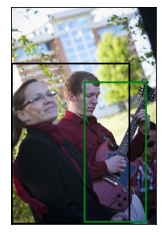

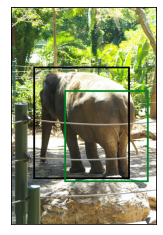

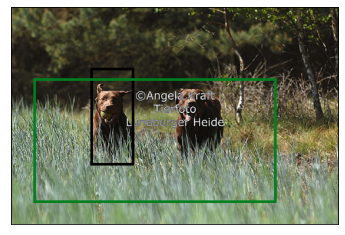

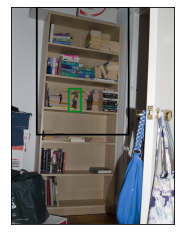

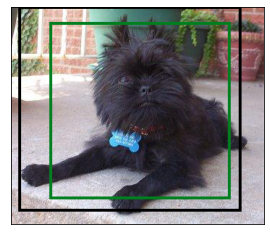

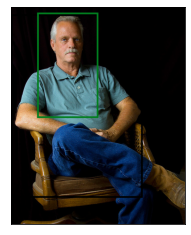

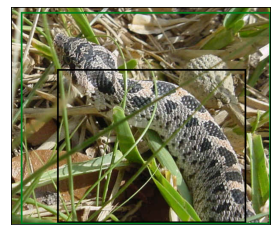

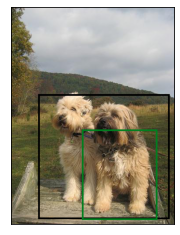

In [ ]:
#score_threshold = .5
#boxes=output['boxes'][output['scores'] > score_threshold]

kval = 2

img_with_boxes = [
    draw_bounding_boxes(F.convert_image_dtype(img, torch.uint8),
                        boxes=output['boxes'][output['labels']!= 100][torch.topk(output['scores'],
                        min(output['scores'].size()[0], kval)).indices], width=4)
    for img, output in zip(images, res)
]
for item in img_with_boxes:
  show(item)

In [ ]:
num = 0
res[num]['labels']

tensor([69,  3, 69,  3, 24, 69, 69,  3, 69, 69, 24,  3,  3,  3,  9,  3,  3,  3,
         3,  3,  9, 24,  3, 69, 11, 69, 69, 69, 11,  3,  3, 77,  3,  3,  3, 91,
        24,  3, 77,  4,  3, 24,  3,  9, 69,  3, 51, 29, 24, 16,  3, 69, 91, 69,
        21, 91, 58, 91, 24,  3, 65,  3,  9, 11,  3, 11,  1], device='cuda:0')

### The truth presented by the targets for comparison:

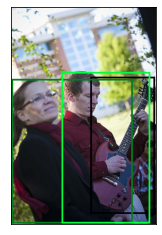

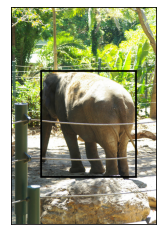

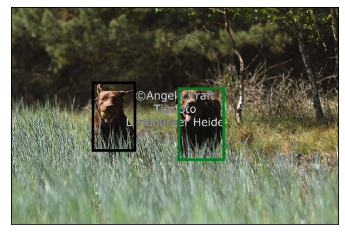

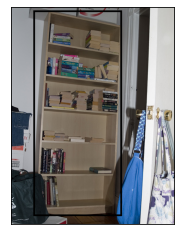

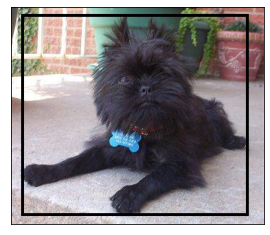

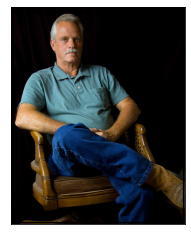

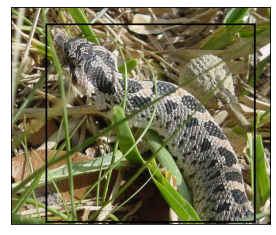

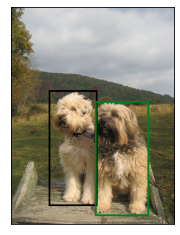

In [ ]:
img_with_boxes = [
    draw_bounding_boxes(F.convert_image_dtype(img, torch.uint8), boxes=output['boxes'], width=4)
    for img, output in zip(images, targets)
]

for item in img_with_boxes:
  show(item)

### Cut the whole model

In [ ]:
model = model.cpu()

In [ ]:
#cutmodel = nn.Sequential(list(model.children())[0], list(model.backbone.children())[0]) #list(model.children())[:2])

In [ ]:
cutmodel_layer1 = nn.Sequential(list(model.children())[0], *list(list(model.backbone.children())[0].children())[0:6])
cutmodel_layer2 = nn.Sequential(list(model.children())[0], *list(list(model.backbone.children())[0].children())[0:7])
cutmodel_layer3 = nn.Sequential(list(model.children())[0], *list(list(model.backbone.children())[0].children())[0:8])
cutmodel_layer4 = nn.Sequential(list(model.children())[0], *list(list(model.backbone.children())[0].children())[0:9])

In [ ]:
cutmodel1 = cutmodel_layer1.to(device).to(device).eval()
cutmodel2 = cutmodel_layer2.to(device).to(device).eval()
cutmodel3 = cutmodel_layer3.to(device).to(device).eval()
cutmodel4 = cutmodel_layer4.to(device).to(device).eval()

In [ ]:
def runmodel(cutmodel, X):
  seq1 = nn.Sequential(list(cutmodel.children())[0])
  seq2 = nn.Sequential(*list(list(cutmodel.children())[1:]))
  return seq2(seq1(X)[0].tensors)

def show_prediction(images, res, kval = 2):
  img_with_boxes = [
      draw_bounding_boxes(F.convert_image_dtype(img, torch.uint8),
                          boxes=output['boxes'][output['labels']!= 100][torch.topk(output['scores'],
                          min(output['scores'].size()[0], kval)).indices], width=4)
      for img, output in zip(images, res)
  ]
  for item in img_with_boxes:
    show(item)

def show_reality(images, targets):
  img_with_boxes = [
      draw_bounding_boxes(F.convert_image_dtype(img, torch.uint8), boxes=output['boxes'], width=4)
      for img, output in zip(images, targets)
  ]

  for item in img_with_boxes:
    show(item)

In [ ]:
#cutmodel

In [ ]:
try:
    del images
    print(2)
    del res
    print(3)
    torch.cuda.empty_cache()
    print("cleared")
except:
    try:
      torch.cuda.empty_cache()
      print("cleared")
    except:
      pass

model = model.to(device).eval()

images, targets = next(iter(labeled_training_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

detection_results = model(images)
res1 = runmodel(cutmodel1, images)
res2 = runmodel(cutmodel2, images)
res3 = runmodel(cutmodel3, images)
res4 = runmodel(cutmodel4, images)

2
cleared


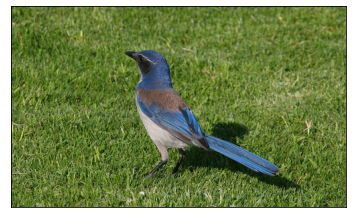

In [ ]:
show(images)

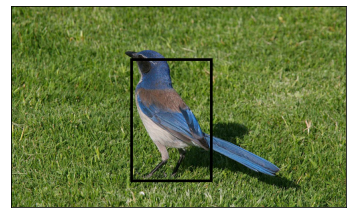

In [ ]:
show_prediction(images, detection_results, 1)

In [ ]:
detection_results

[{'boxes': tensor([[178.7820,  78.4207, 300.0518, 262.4468],
          [153.0166,  79.6005, 407.8224, 275.8062],
          [152.2182,  52.6258, 436.3107, 300.0000],
          [176.6213,  59.0356, 243.0272, 157.1668],
          [155.5319,  64.3955, 315.8665, 251.5725],
          [252.7259, 178.0018, 406.8541, 265.3062],
          [130.1992,  29.6785, 453.1095, 260.4593],
          [286.8887, 202.2170, 430.6126, 280.1555],
          [158.0052,  38.0558, 415.7430, 300.0000],
          [172.7124,  65.4528, 275.3246, 199.6379]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([ 1,  1,  4,  1,  4,  1, 93,  1, 71,  4], device='cuda:0'),
  'scores': tensor([0.8295, 0.6628, 0.4149, 0.2151, 0.1590, 0.1518, 0.1116, 0.0885, 0.0777,
          0.0550], device='cuda:0', grad_fn=<IndexBackward0>)}]

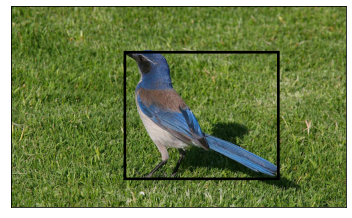

In [ ]:
show_reality(images, targets)

In [ ]:
print(res1.size())
print(res2.size())
print(res3.size())
print(res4.size())

torch.Size([1, 256, 264, 200])
torch.Size([1, 512, 132, 100])
torch.Size([1, 1024, 66, 50])
torch.Size([1, 2048, 33, 25])


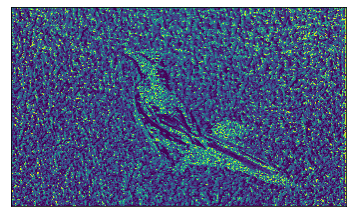

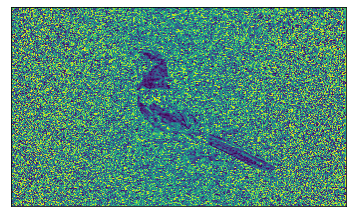

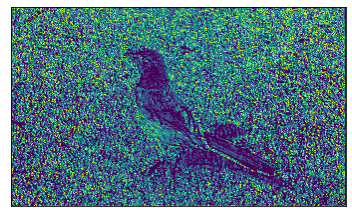

In [ ]:
show(res1[0,0])
show(res1[0,1])
show(res1[0,2])

In [ ]:
#show(res2[0,0])
#show(res2[0,1])
#show(res2[0,2])

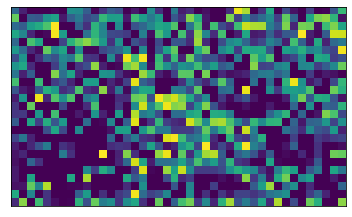

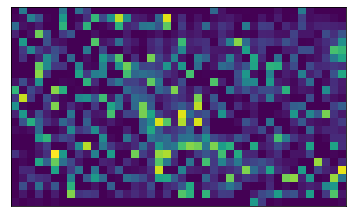

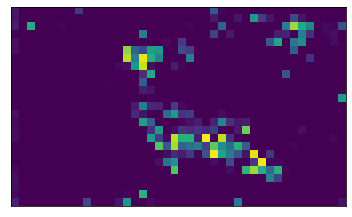

In [ ]:
show(res4[0,0])
show(res4[0,1])
show(res4[0,2])

### Other example


In [314]:
try:
    del images
    print(2)
    del res
    print(3)
    torch.cuda.empty_cache()
    print("cleared")
except:
    try:
      torch.cuda.empty_cache()
      print("cleared")
    except:
      pass

model = model.to(device).eval()

images, targets = next(iter(labeled_validation_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

detection_results = model(images)
res1 = runmodel(cutmodel1, images)
res2 = runmodel(cutmodel2, images)
res3 = runmodel(cutmodel3, images)
res4 = runmodel(cutmodel4, images)

2
cleared


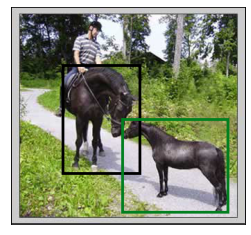

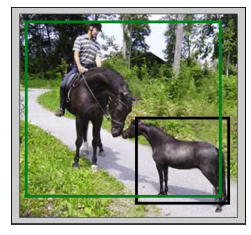

In [315]:
show_reality(images, targets)
show_prediction(images, detection_results, 2)

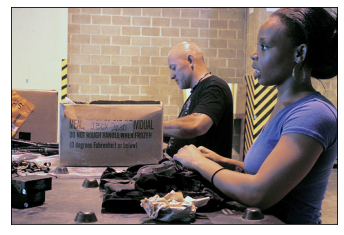

In [ ]:
show(images)

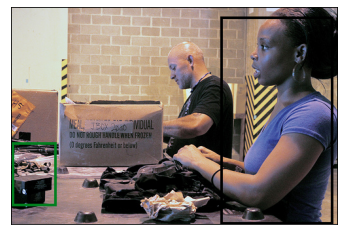

In [259]:
show_prediction(images, detection_results, 2)

In [ ]:
detection_results

[{'boxes': tensor([[3.2062e+02, 1.6559e+01, 4.9274e+02, 3.3300e+02],
          [1.7172e+00, 2.0864e+02, 6.9117e+01, 3.0545e+02],
          [3.3087e+01, 1.1977e+01, 3.4738e+02, 3.1805e+02],
          [2.3880e+02, 6.3854e+01, 3.4501e+02, 2.4636e+02],
          [0.0000e+00, 1.3616e+02, 3.7455e+01, 2.1249e+02],
          [3.8715e+01, 6.3833e+01, 4.5112e+02, 3.3300e+02],
          [2.1249e+02, 5.7146e+01, 3.6734e+02, 3.1791e+02],
          [1.5312e+02, 2.1364e+02, 3.8182e+02, 3.3088e+02],
          [2.0663e+02, 1.8157e+02, 3.4854e+02, 3.2396e+02],
          [5.9536e+01, 6.5886e+01, 4.4943e+02, 3.2893e+02],
          [2.3471e+02, 1.9232e+02, 3.2932e+02, 2.2385e+02],
          [2.3997e+02, 8.4935e+01, 2.8318e+02, 1.7249e+02],
          [2.2408e+02, 1.9936e+02, 2.6757e+02, 2.5525e+02],
          [1.6889e+02, 3.0947e+01, 4.8965e+02, 3.1996e+02],
          [2.2666e+02, 7.7794e+01, 3.5157e+02, 2.9633e+02],
          [1.3930e+02, 2.5476e+02, 2.0269e+02, 3.1907e+02],
          [2.2802e+02, 4.8160e+

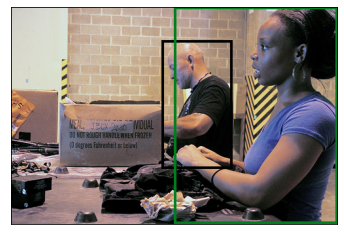

In [ ]:
show_reality(images, targets)

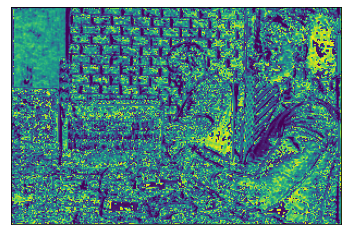

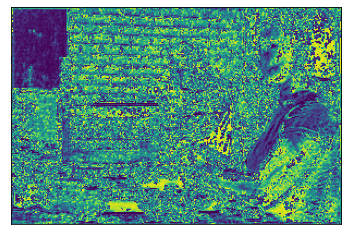

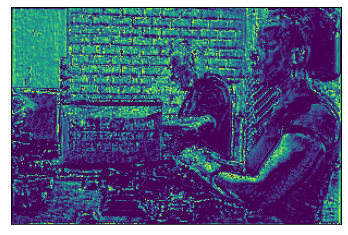

In [ ]:
show(res1[0,0])
show(res1[0,1])
show(res1[0,2])

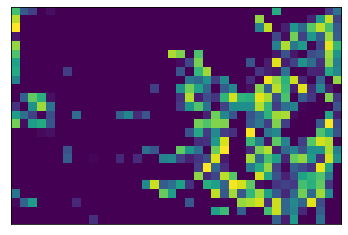

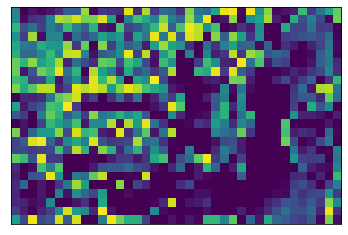

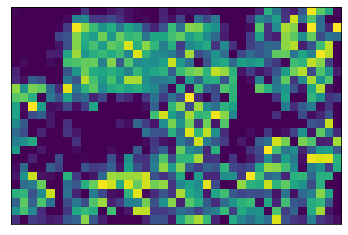

In [ ]:
show(res4[0,40])
show(res4[0,41])
show(res4[0,42])